### Objective of the notbook.
1. Reducing the number of Parameters.


Output
*   Model Parameters: 8,116
*   Best Train Accuracy: 99.19%
*   Best Test Accuracy: 98.33%

### What can be improved?

Adding batch normalization: improves the accuracy

Adding Drop Out: reduces the gap between test and train losses

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt

In [0]:
# Create the data reader and transformer
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))])


In [0]:
train = datasets.MNIST('./data',
                       train=True,
                       transform = train_transform,
                       download = True)
test = datasets.MNIST('./data',
                       train=False,
                       transform = test_transform,
                       download = True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
# Set seed for all the environments
SEED = 1
torch.manual_seed(SEED)

CUDA = torch.cuda.is_available()
print("CUDA is available:",CUDA)
# If CUDA is available the set SEED for it
if CUDA:
    torch.cuda.manual_seed(SEED)


CUDA is available: True


In [0]:
# DATA LOADER
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if CUDA else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


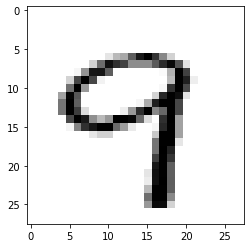

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

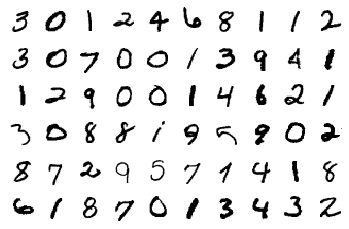

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # FIRST LAYER
        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels = 1,
                                      out_channels = 4,
                                      kernel_size=3, 
                                      stride = 1,
                                      padding=0,
                                      bias=True
                                      ),                                         #output size = 26 Receptive field = 3
                              nn.ReLU()
                              )
        # CONVOLUTION BLOCK
        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=4,
                                                    out_channels=8,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output Size = 24, Receptive Field = 5
                                          nn.ReLU()
        ) 
        self.conv_block_3 = nn.Sequential(nn.Conv2d(in_channels=8,
                                                    out_channels=16,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output size = 22 Receptive field = 7
                                          nn.ReLU()
        )
        
        # TRANSITION BLOCK
        self.pool_1 = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)             #  #Output size = 11 Receptive field = 8
        self.conv_block_4 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                    out_channels=4,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output size = 11 Receptive field = 10
                                          nn.ReLU()
        )

        # CONVOLUTION BLOCK
        self.conv_block_5 = nn.Sequential(nn.Conv2d(in_channels=4,
                                                    out_channels=8,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output size = 9 Receptive field = 14
                                          nn.ReLU()
        )
        self.conv_block_6 = nn.Sequential(nn.Conv2d(in_channels=8,
                                                    out_channels=16,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output size = 7 Receptive field = 18
                                          nn.ReLU()
        )

        # OUTPUT LAYER
        self.conv_block_7 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                    out_channels=10,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output size = 7 Receptive field = 20
                                          nn.ReLU()
        )
        self.conv_block_8 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                    out_channels=10,
                                                    kernel_size=7,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True)                 #Output size = 1 Receptive field = 26
        ) 

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.pool_1(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = self.conv_block_6(x)
        x = self.conv_block_7(x)
        x = self.conv_block_8(x)
        x = x.view(-1, 10)
        final_x = F.log_softmax(x, dim=-1)
        return final_x

In [0]:
device = torch.device("cuda" if CUDA else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
            Conv2d-3            [-1, 8, 24, 24]             296
              ReLU-4            [-1, 8, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           1,168
              ReLU-6           [-1, 16, 22, 22]               0
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8            [-1, 4, 11, 11]              68
              ReLU-9            [-1, 4, 11, 11]               0
           Conv2d-10              [-1, 8, 9, 9]             296
             ReLU-11              [-1, 8, 9, 9]               0
           Conv2d-12             [-1, 16, 7, 7]           1,168
             ReLU-13             [-1, 16, 7, 7]               0
           Conv2d-14             [

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.4215056896209717 Batch_id=468 Accuracy=30.78: 100%|██████████| 469/469 [00:11<00:00, 41.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3087, Accuracy: 9127/10000 (91.27%)

EPOCH: 1


Loss=0.1759369820356369 Batch_id=468 Accuracy=94.25: 100%|██████████| 469/469 [00:11<00:00, 41.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1120, Accuracy: 9658/10000 (96.58%)

EPOCH: 2


Loss=0.22223417460918427 Batch_id=468 Accuracy=96.70: 100%|██████████| 469/469 [00:10<00:00, 42.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0849, Accuracy: 9737/10000 (97.37%)

EPOCH: 3


Loss=0.09152528643608093 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:11<00:00, 42.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0822, Accuracy: 9746/10000 (97.46%)

EPOCH: 4


Loss=0.05305388942360878 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0673, Accuracy: 9795/10000 (97.95%)

EPOCH: 5


Loss=0.01257336139678955 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:11<00:00, 42.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9787/10000 (97.87%)

EPOCH: 6


Loss=0.0782390907406807 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:11<00:00, 42.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0709, Accuracy: 9758/10000 (97.58%)

EPOCH: 7


Loss=0.02543744444847107 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:10<00:00, 43.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9821/10000 (98.21%)

EPOCH: 8


Loss=0.06294728070497513 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:10<00:00, 43.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9817/10000 (98.17%)

EPOCH: 9


Loss=0.020416369661688805 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:10<00:00, 43.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 9824/10000 (98.24%)

EPOCH: 10


Loss=0.009511535055935383 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:10<00:00, 48.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9824/10000 (98.24%)

EPOCH: 11


Loss=0.01936209201812744 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:10<00:00, 42.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9800/10000 (98.00%)

EPOCH: 12


Loss=0.014415125362575054 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:10<00:00, 42.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0624, Accuracy: 9792/10000 (97.92%)

EPOCH: 13


Loss=0.0065057179890573025 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:10<00:00, 44.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9833/10000 (98.33%)

EPOCH: 14


Loss=0.010328720323741436 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:10<00:00, 51.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9822/10000 (98.22%)

EPOCH: 15


Loss=0.040583621710538864 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:10<00:00, 43.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9832/10000 (98.32%)

EPOCH: 16


Loss=0.02542153000831604 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:10<00:00, 44.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9814/10000 (98.14%)

EPOCH: 17


Loss=0.0448438823223114 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:10<00:00, 51.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9819/10000 (98.19%)

EPOCH: 18


Loss=0.009678065776824951 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:10<00:00, 44.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Accuracy: 9828/10000 (98.28%)

EPOCH: 19


Loss=0.03176473453640938 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:10<00:00, 44.92it/s]



Test set: Average loss: 0.0520, Accuracy: 9833/10000 (98.33%)



Text(0.5, 1.0, 'Test Accuracy')

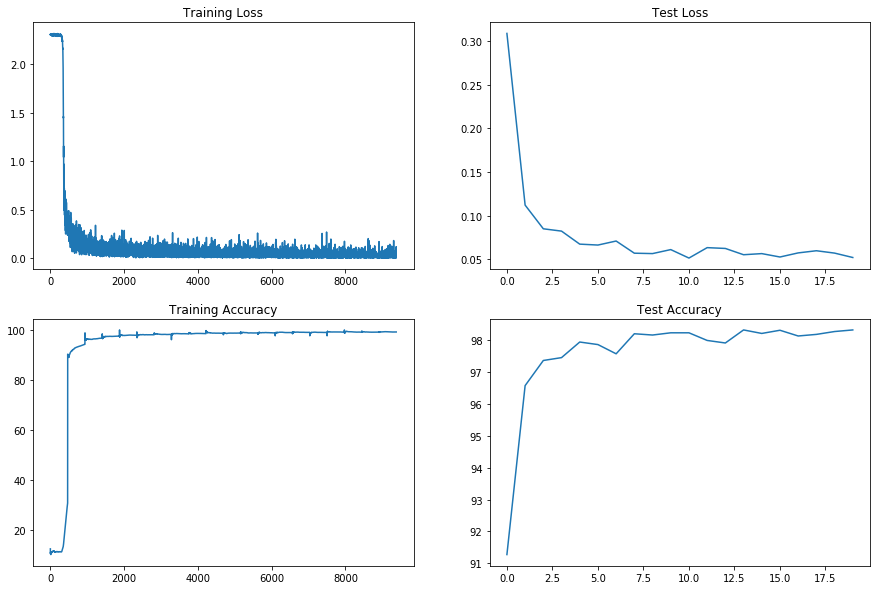

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
import numpy as np
train_acc_np = np.array(train_acc)
train_acc_np_reshaped = train_acc_np.reshape(20,469)

In [0]:
train_acc_np_reshaped.mean(axis=1)

array([14.22256268, 92.5586969 , 96.43034996, 97.40476002, 97.87858031,
       98.05602095, 98.27121988, 98.47624618, 98.57256077, 98.78963008,
       98.71115586, 98.85453085, 98.8883819 , 98.98162655, 99.0668418 ,
       99.0101812 , 99.19058679, 99.20670814, 99.16139339, 99.22594179])